In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, shutil, pickle, shelve
from Bio import SeqIO
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model, Model
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten, Conv1D, LSTM, CuDNNLSTM, Bidirectional
from keras.optimizers import RMSprop, Adam
from keras.initializers import glorot_normal
import keras
from utilities import sampling, one_hot_encoding, curtail, get_training_data, load_data, data_split, dianostic_plots, pad_for_detector

Using TensorFlow backend.


In [3]:
# sample data from:
data_dir = "/home/ubuntu/group_volume/team_neural_network/data/input/3.24_species_only"
output_folder_path = "../../../../temp/buffers/"

## 1. Training and validation

In [4]:
input_folder_path = "../../../../temp/samples/"
# Subset sampling: save to ss_samples
output_folder_path = "../../../../temp/buffers/ss_samples"

data_dir = "/home/ubuntu/group_volume/team_neural_network/data/input/3.24_species_only"

len(os.listdir(data_dir)) # total number of regions

3543

Uncomment the following two code chunks to resample the data

In [5]:
# !rm -r /home/ubuntu/data/temp/samples
# !mkdir /home/ubuntu/data/temp/samples

In [6]:
# all_data_lst = np.array(os.listdir(data_dir))
# num_samples = 209

# sampling(data_dir, input_folder_path, num_samples, seed = 189)

# output_file_path = os.path.join(output_folder_path, 'sampled_data.data')
# train_regions = one_hot_encoding(input_folder_path, output_file_path)

# data_x, data_y = get_training_data(train_regions, output_folder_path,
#                                    max_len = 1000, 
#                                    train_x_name = 'train_x.data', 
#                                    train_y_name = 'train_y.data')

In [7]:
data_x = pickle.load(open('../../../../temp/buffers/ss_samples/train_x.data', 'rb'))
data_y = pickle.load(open('../../../../temp/buffers/ss_samples/train_y.data', 'rb'))
train_x, train_y, val_x, val_y = data_split(data_x, data_y, seed = 157)
train_x, val_x = pad_for_detector(train_x, 10), pad_for_detector(val_x, 10)

5016 (4013, 1000, 4) (4013,) (1003, 1000, 4) (1003,)


In [8]:
def get_hybrid(opt):
    """  Return a hybrid network given a optimizer
    """
    model = Sequential()
    model.add(Conv1D(filters = 15, 
                     kernel_size = 10, 
                     padding = 'valid',
                     data_format = 'channels_last',
                     activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 5, strides = 5))
    model.add(Dropout(0.6))
    model.add(Bidirectional(LSTM(10)))
    model.add(Dropout(0.7))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
    return model

def train(model, train_x, train_y, val_data, config = {'epochs': 35, 'batch_size': 256}):
    """  Train model for a given config, training data, and validation data
    """
    epochs, batch_size = config['epochs'], config['batch_size']
    return model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=val_data)

In [10]:
# Start training
# Set up some configurations
optimizers = {'adam': Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-2, amsgrad=False),
              'rmsprop': RMSprop(lr=1e-2, rho=0.9, epsilon=None, decay=1e-2)}
config = {'epochs': 35, 'batch_size': 256}
opt = optimizers['rmsprop']
model = get_hybrid(opt)
history = train(model, train_x, train_y, (val_x, val_y), config)

Train on 4013 samples, validate on 1003 samples
Epoch 1/35
4013/4013 [==============================] - 31s 8ms/step - loss: 0.6972 - acc: 0.5138 - val_loss: 0.6882 - val_acc: 0.5095
Epoch 2/35
4013/4013 [==============================] - 11s 3ms/step - loss: 0.6894 - acc: 0.5378 - val_loss: 0.6804 - val_acc: 0.6311
Epoch 3/35
4013/4013 [==============================] - 11s 3ms/step - loss: 0.6796 - acc: 0.5696 - val_loss: 0.6633 - val_acc: 0.5703
Epoch 4/35
4013/4013 [==============================] - 11s 3ms/step - loss: 0.6685 - acc: 0.5709 - val_loss: 0.6530 - val_acc: 0.6321
Epoch 5/35
4013/4013 [==============================] - 11s 3ms/step - loss: 0.6563 - acc: 0.6010 - val_loss: 0.6368 - val_acc: 0.6281
Epoch 6/35
4013/4013 [==============================] - 11s 3ms/step - loss: 0.6509 - acc: 0.6085 - val_loss: 0.6198 - val_acc: 0.6989
Epoch 7/35
4013/4013 [==============================] - 12s 3ms/step - loss: 0.6403 - acc: 0.6319 - val_loss: 0.6008 - val_acc: 0.7069
Epoch 8

In [11]:
# Save the model for later analysis
save_model_path = '/home/ubuntu/data/team_neural_network/code/models'
model_name = 'hybrid_net-motif.h5'
model.save(os.path.join(save_model_path, model_name))

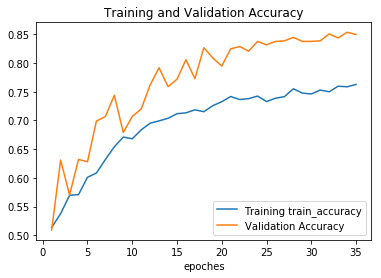

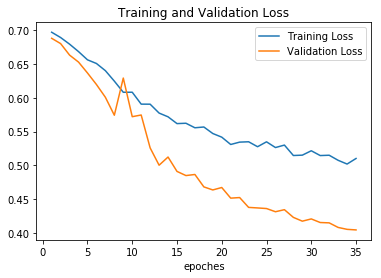

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

dianostic_plots(acc, loss, val_acc, val_loss)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1009, 15)          615       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 201, 15)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 201, 15)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total para